In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

2024-12-21 11:20:30.816382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 11:20:31.179717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-21 11:20:32.797960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "patatos",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


2024-12-21 11:20:37.061403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-21 11:20:37.062493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Import data into tensorflow dataset object
We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
class_name = dataset.class_names

In [5]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 2 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 2 0 0 2 0 0 1 2 1 0 0]


2024-12-21 11:20:37.559782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


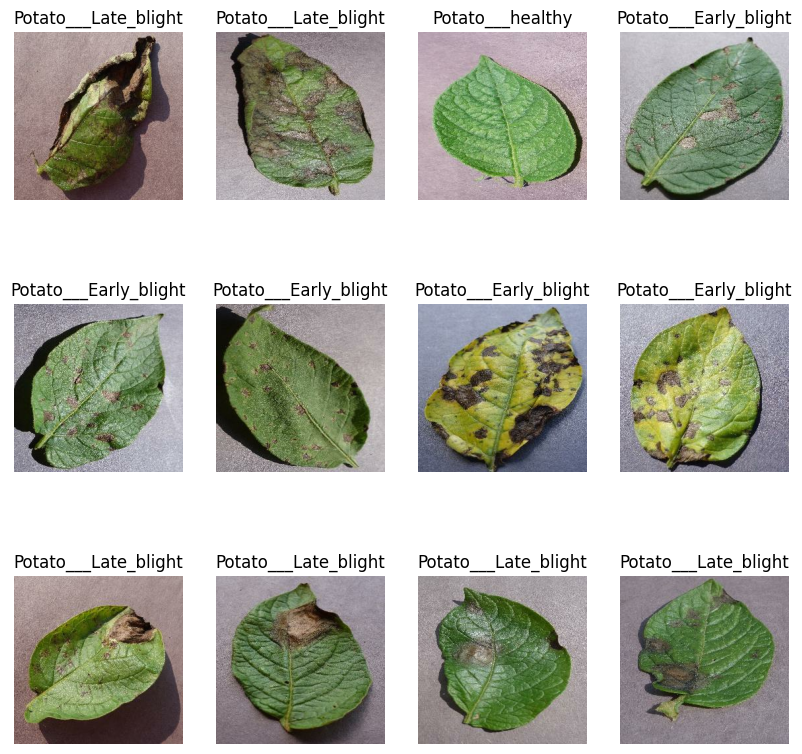

In [6]:
plt.figure(figsize = (10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_name[labels_batch[i]])

In [7]:
# 80 % = traning 
# validation 10%
# 10 % testing 

In [8]:
train_size =0.8
len(dataset)

68

In [9]:
train_ds = dataset.take(54)

In [10]:
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size =  0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [14]:
def get_dataset_partition_tf(ds,train_split =0.8,val_split =0.1,test_split =0.1,shuffle=True,shuffle_size = 10000):
    assert(train_split+test_split+val_split)== 1 # this is an assertion like, the sum of the three in assert must be 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size ,seed =12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [15]:
train_ds ,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
for image_batch,labels_batch in dataset.take(1):\
    print(image_batch[0].numpy)


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[163., 161., 172.],
        [129., 127., 138.],
        [108., 106., 117.],
        ...,
        [163., 161., 175.],
        [158., 156., 170.],
        [153., 151., 165.]],

       [[149., 147., 158.],
        [ 98.,  96., 107.],
        [144., 142., 153.],
        ...,
        [159., 157., 171.],
        [165., 163., 177.],
        [168., 166., 180.]],

       [[100.,  98., 109.],
        [117., 115., 126.],
        [188., 186., 199.],
        ...,
        [163., 161., 175.],
        [164., 162., 176.],
        [164., 162., 176.]],

       ...,

       [[142., 138., 153.],
        [120., 116., 131.],
        [136., 132., 147.],
        ...,
        [180., 178., 191.],
        [178., 176., 189.],
        [189., 187., 200.]],

       [[118., 114., 129.],
        [102.,  98., 113.],
        [157., 153., 168.],
        ...,
        [177., 175., 188.],
        [172., 170., 183.],
       

2024-12-21 11:20:38.752587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Normalization layer 

In [20]:
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [21]:
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [22]:
from tensorflow.keras import layers, models

# Define input image dimensions and number of classes
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Preprocessing layer (resizing and rescaling)
resize_and_rescale = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE,input_shape=(BATCH_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.Rescaling(1./255),
])

# Define the model
model = models.Sequential([
    resize_and_rescale,  # Apply the preprocessing
    # 5
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Compile the model (if needed before training)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model is now ready for training


/home/anubhav/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/anubhav/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 848ms/step - accuracy: 0.4720 - loss: 0.9264 - val_accuracy: 0.5885 - val_loss: 0.8951
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 779ms/step - accuracy: 0.5979 - loss: 0.8243 - val_accuracy: 0.7344 - val_loss: 0.5526
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.7141 - loss: 0.5788 - val_accuracy: 0.8594 - val_loss: 0.3206
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 669ms/step - accuracy: 0.8428 - loss: 0.3812 - val_accuracy: 0.8802 - val_loss: 0.2952
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 667ms/step - accuracy: 0.9005 - loss: 0.2608 - val_accuracy: 0.9323 - val_loss: 0.1905
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 669ms/step - accuracy: 0.9135 - loss: 0.2261 - val_accuracy: 0.9375 - val_loss: 0.1416
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 670ms/step - accuracy: 0.9389 - loss: 0.1567 - val_accuracy: 0.8802 - val_loss: 0.2695
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 659ms/step - accuracy: 0.9336 - loss: 0.1565 - val_accu

In [26]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9833 - loss: 0.0566


In [27]:
history

In [28]:
 print(history.params)

{'verbose': 1, 'epochs': 20, 'steps': 54}


In [29]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [30]:
history.history['loss']

[0.9270904064178467,
 0.7299532890319824,
 0.5130090117454529,
 0.37359175086021423,
 0.2661277949810028,
 0.20152877271175385,
 0.15293340384960175,
 0.14985226094722748,
 0.1548590511083603,
 0.12236904352903366,
 0.09616708010435104,
 0.0679273009300232,
 0.05778452754020691,
 0.05425061285495758,
 0.061080001294612885,
 0.09924089163541794,
 0.02454850636422634,
 0.021539583802223206,
 0.020899204537272453,
 0.018272357061505318]

In [31]:
history.history['accuracy']

[0.4774305522441864,
 0.6568287014961243,
 0.7696759104728699,
 0.8483796119689941,
 0.8987268805503845,
 0.9224537014961243,
 0.9386574029922485,
 0.9380787014961243,
 0.9409722089767456,
 0.9577546119689941,
 0.9594907164573669,
 0.9751157164573669,
 0.9780092835426331,
 0.9809027910232544,
 0.9733796119689941,
 0.9635416865348816,
 0.9918981194496155,
 0.9901620149612427,
 0.9901620149612427,
 0.9936342835426331]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

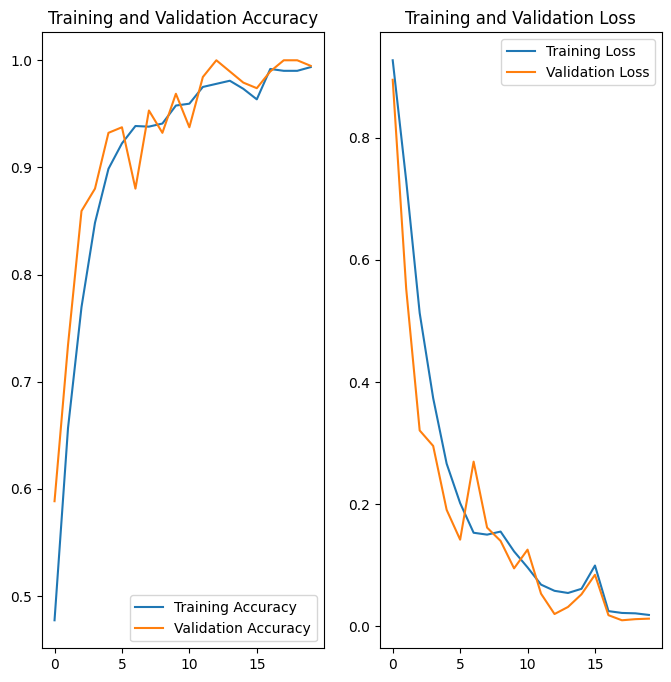

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

label 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
[6.6675128e-08 9.9999988e-01 2.0162566e-11]
1
actual 1 preicted 1


2024-12-21 12:06:23.007132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


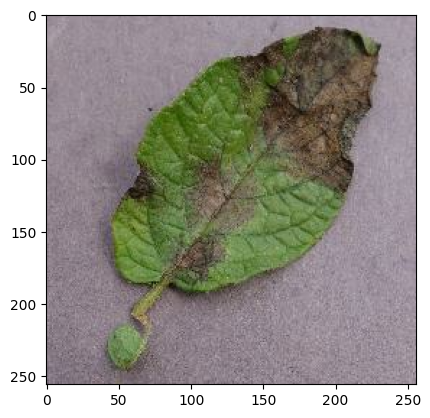

In [113]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype("uint8")
    plt.imshow(first_img)
    print("label",labels_batch[0].numpy())
    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print(f"actual {labels_batch[0].numpy()} preicted {np.argmax(batch_prediction[0])}")

In [121]:
def predict(model,img):
    # img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array =tf.expand_dims(img_array,0) #create a batch
    predictions = model.predict(img_array)
    predict_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predict_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-12-21 12:09:02.145140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


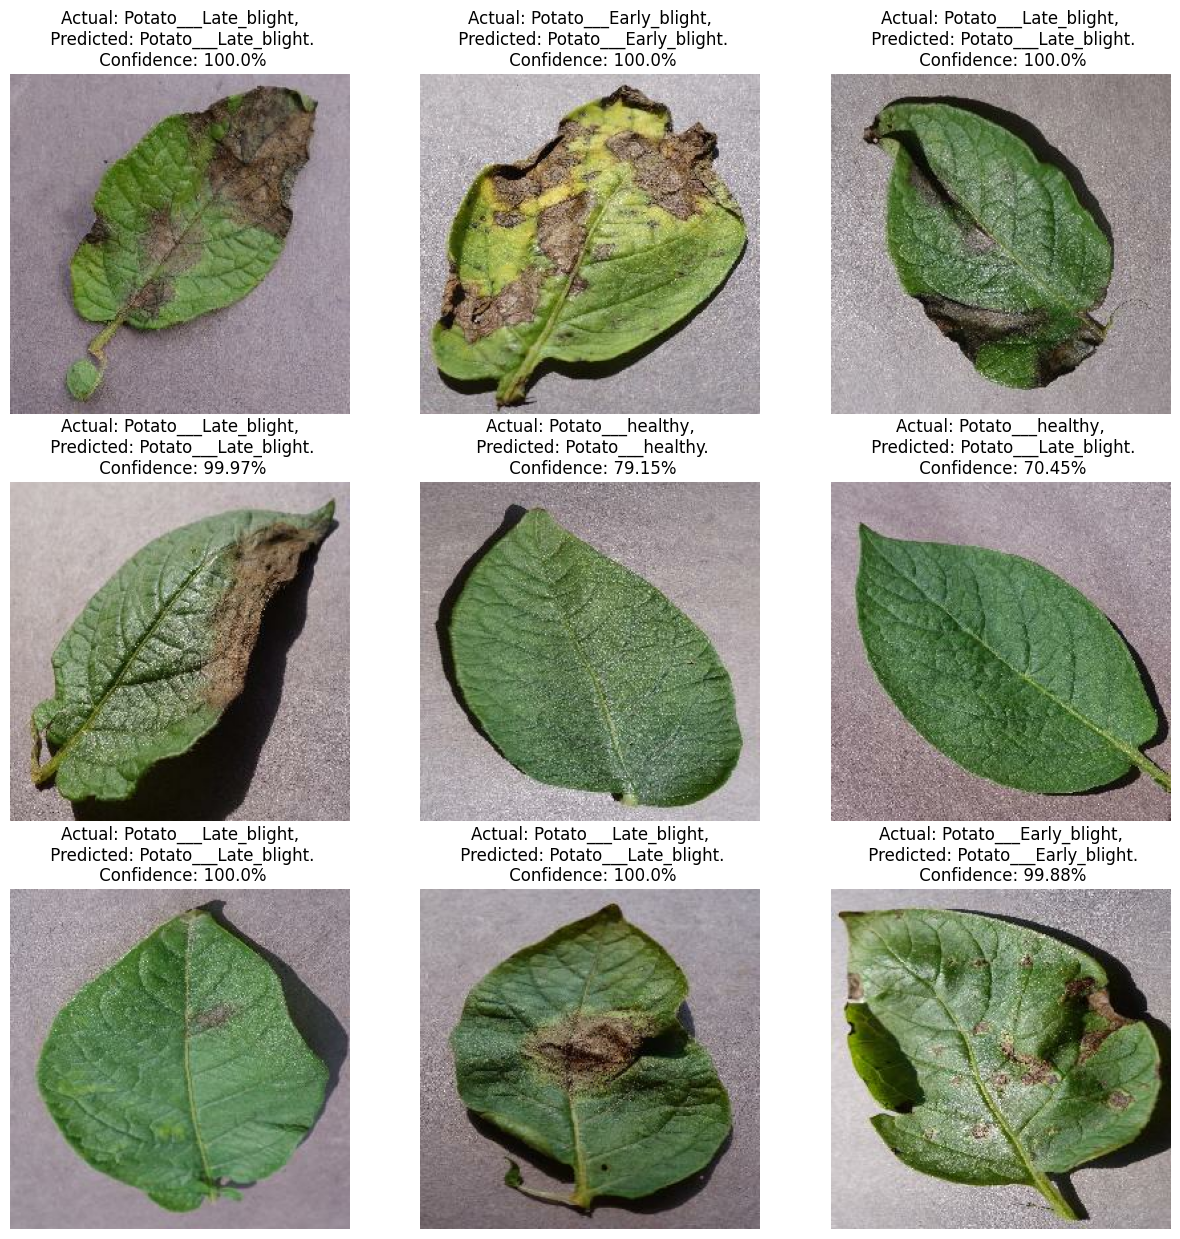

In [125]:
plt.figure(figsize=(15, 15))
for image,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, image[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [140]:
import os
import tensorflow as tf

# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)

# Specify model version
# model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model_version = 1
# Save the model in Keras native format
model.save(f"models/model_v{model_version}.keras")

print(f"Model saved successfully at models/model_v{model_version}.keras")


Model saved successfully at models/model_v1.keras
